## Import Dependencies

In [141]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## A Simple Function

In [142]:
def f(x):
    return 3*x**2 - 4*x + 5

In [143]:
f(3.0)

20.0

## Plot `f` For Different Values Of `x`

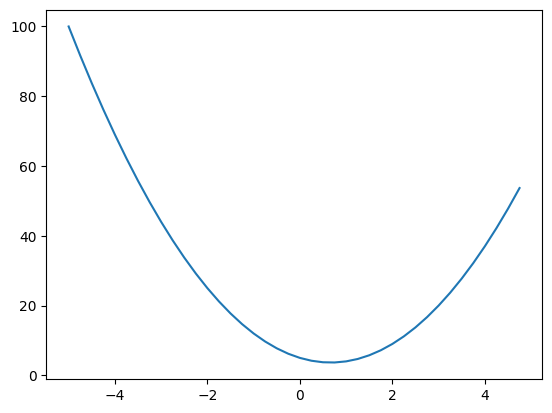

In [144]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

## Finding The [Derivative](https://en.wikipedia.org/wiki/Derivative)

A derivative lets you figure out how fast something is changing by looking at how it's changing over a really, really, really tiny amount of time. It's like taking a super close-up picture of something and seeing how it's changing just between two tiny moments.

In [126]:
from IPython.display import display, Math

derivative = r"\frac{d}{dx} f(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}"
display(Math(derivative))

<IPython.core.display.Math object>

In [145]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

## Les Get More Complex

In [146]:
def d(a, b, c):
    return a*b + c

In [147]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = d(a, b, c)

# find the derivative of d function wrt c by increasing c by a tiny amount
c += h

d2 = d(a, b, c)

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [148]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = d(a, b, c)

# find the derivative of d function wrt b by increasing b by a tiny amount
b += h

d2 = d(a, b, c)

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


## Neural Network Node

In [163]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # derivative of l with respect to the value
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        
        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

In [150]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

## Graph Visualization Of Neural Network

In [80]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

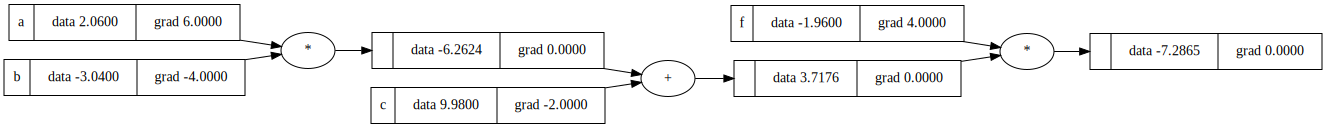

In [157]:
draw_dot(L)

## Manual Backpropagation
Start here at the end and we're going to go reverse and calculate the gradient along all these intermediate values and really what we're computing for every single value here is the derivative of that node with respect to `L`. 

The derivative of `L` with respect to `L` is just `1` and then we're going to derive what is the derivative of `L` with respect to `f`, with respect to `d`, with respect to `c` with respect to `e`, with respect to `b`, and with respect to `a` and in the neural network setting you'd be very interested in the derivative of basically this loss function `L` with respect to the weights of a neural network and here of course we have just these variables `a`, `b`, `c` and `f` but some of these will eventually represent the weights of a neural net and so we'll need to know how those weights are impacting the loss function. 

We're interested basically in the derivative of the output with respect to some of its leaf nodes and those leaf nodes will be the weights of the neural net and the other leaf nodes of course will be the data itself but usually we will not want or use the derivative of the loss function with respect to data because the data is fixed but the weights will be iterated on using the gradient information. 


In [152]:
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b;
    e.label = 'e'
    d = e + c;
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f;
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a * b;
    e.label = 'e'
    d = e + c;
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f;
    L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)


lol()

-3.9999999999995595


In [97]:
display(Math(r"L = d*f"))
display(Math(r"\frac {dL} {dL} = 1"))
display(Math(r"\frac {dL} {df} = \frac {(d+h)*f - (d*f)} {h} = d"))
display(Math(r"\frac {dL} {dd} = f"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [153]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data

Gradient check is when we are deriving gradients using backpropagation and getting the derivative with respect to all the intermediate results.

Numerical gradient is just estimating it using small step size.

Now we're getting to the crux of backpropagation. So this will be the most important node to understand because if you understand the gradient for this node you understand all of backpropagation and all of training of neural nets basically.

So we need to derive `dL` by `dc` in other words the derivative of `L` with respect to `c`. How is `L` sensitive to c so if we wiggle `c` how does that impact `L`.

We know how `c` impacts `d` and so just very intuitively if you know the impact that `c` is having on `d` and the impact `d` is having on `L`, we can calculate the impact of `c` on `L`.

In [98]:
display(Math(r"d = e+c"))
display(Math(r"\frac {dd} {dc} = \frac {(c+h) + e - (c+e)} {h} = 1.0"))
display(Math(r"\frac {dL} {de} = 1.0"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

So, we know how `L` impacts `d` and now we know how `c` and `e` impact `d`, how do we put that information together to write `dl` by `dc` and the answer of course is the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) in calculus.

If a variable `z` depends on the variable `y`, which itself depends on the variable `x` (that is, `y` and `z` are dependent variables), then `z` depends on `x` as well, via the intermediate variable `y`. In this case, the chain rule is expressed as:



In [99]:
display(Math(r"\frac {dz} {dx} = \frac {dz} {dy} * \frac {dy} {dx}"))


<IPython.core.display.Math object>


What it means for us is a really exactly the same thing:


In [100]:
display(Math(r"\frac {dL} {dc} = \frac {dL} {dd} * \frac {dd} {dc}"))

<IPython.core.display.Math object>

In [154]:
c.grad = d.grad * 1
e.grad = d.grad * 1

Essentially the `+` just directly routes the gradients back.

In [104]:
display(Math(r"e = a * b"))
display(Math(r"\frac {dL} {da} = \frac {dL} {de} * \frac {de} {da}"))
display(Math(r"\frac {dL} {db} = \frac {dL} {de} * \frac {de} {db}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [155]:
a.grad = e.grad * b.data
b.grad = e.grad * a.data

That's what back propagation is, just a recursive application of chain rule backwards through the computation graph.

Let's see this power in action just very briefly. What we're going to do is we're going to nudge our inputs to try to make `L` go up.

In [156]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# run the forward pass again
e = a * b
d = e + c
L = d * f

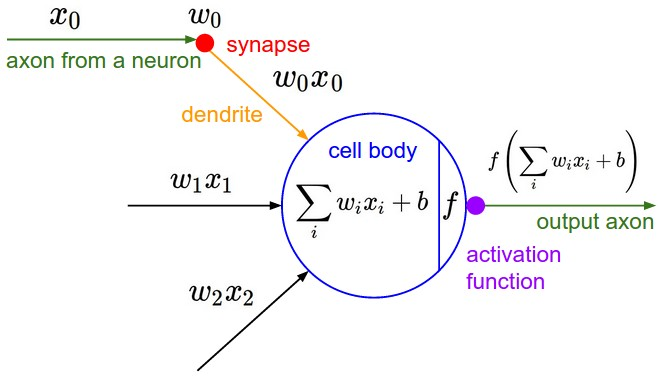

In [116]:
from IPython import display
display.Image("https://cs231n.github.io/assets/nn1/neuron_model.jpeg")

So we want to eventually build up neural networks and in the simplest case these are multilateral perceptrons. This is a two layer neural net and it's got these hidden layers made up of neurons and these neurons are fully connected to each other. Biological neurons are very complicated devices but we have very simple mathematical models of a neuron, you have some inputs axis and then you have these synapses that have weights on them, the w's are weights and then the synapse interacts with the input to. 

This neuron multiplicative so what flows to the cell body of this neuron is w times x but there's multiple inputs so there's many w times x's flowing into the cell body. The cell body has also like some bias so this is kind of like the inert innate sort of trigger (happiness) of this neuron so this bias can make it a bit more trigger happy or a bit less trigger happy regardless of the input.

Basically we're taking all the w times x of all the inputs adding the bias and then we take it through an activation function and this activation function is usually some kind of a squashing function like a sigmoid or tanh.

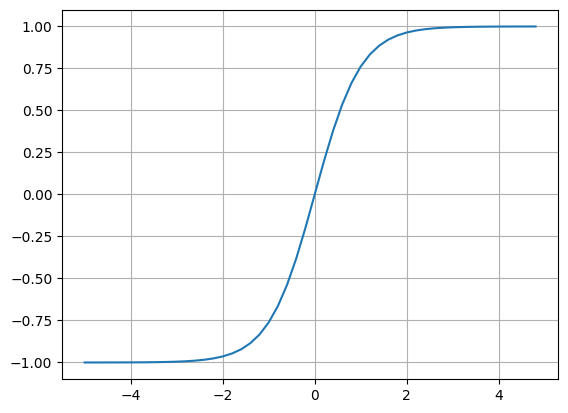

In [117]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [158]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

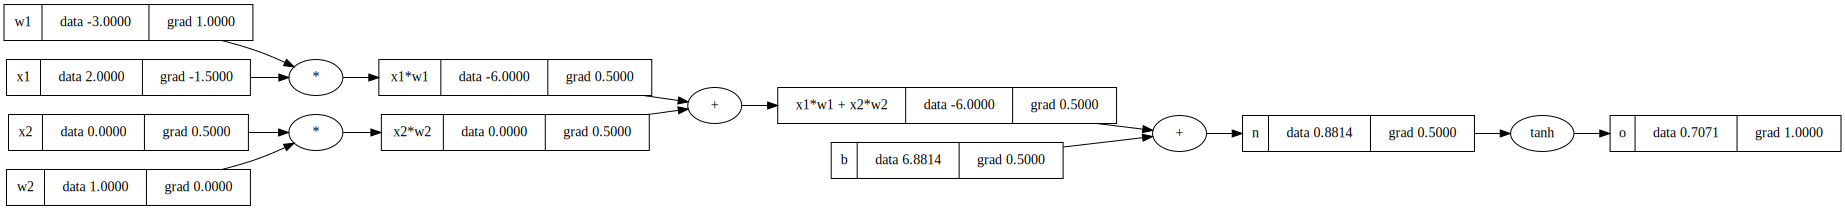

In [161]:
draw_dot(o)

In [129]:
display(Math(r"o = tanh(n)"))
display(Math(r"\frac {do} {dn} = 1 - tanh(n)^2"))
display(Math(r"\frac {do} {dn} = 1 - o^2"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's get rid of doing backpropagation manually by implementing the `backward` function for a whole expression graph. We have to make sure that the backward function calculates the gradients of a node only after calculating the gradients of all the nodes ahead of it in the graph. To do this we'll do a topological sort on the graph.

```
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo
```

In [160]:
o.backward()

In [173]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'

In [174]:
o.backward()

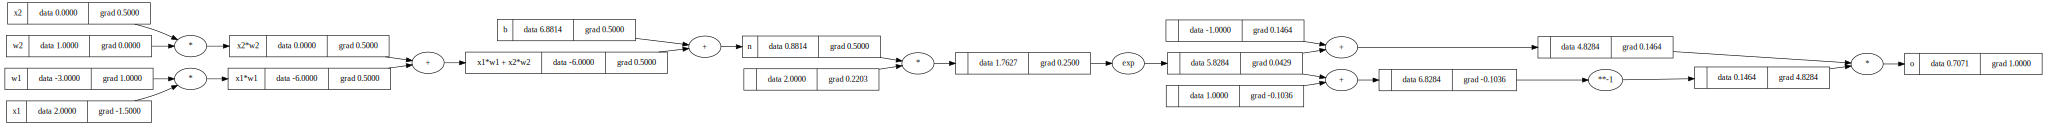

In [175]:
draw_dot(o)